**XGBoost univariate model for the prediction of meteorological time series data.**

**XGBoost for forecasting**
*Code used and adapted from reference:*  **https://medium.com/@geokam/time-series-forecasting-with-xgboost-and-lightgbm-predicting-energy-consumption-460b675a9cee**

# **IMPORT LIBRARIES**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import xgboost as xgb

from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

color_pal = sns.color_palette()

# **DATA MANIPULATION**

In [3]:
#--- LOAD DATA ---#
location = 'TIME-SERIES-Diario-13-23.csv'  ## DAILY DATA
# location = 'TIME-SERIES-Mensual-86-23.csv' ## MONTHLY DATA

df = pd.read_csv(location, delimiter=',')
df.head()

,Año,Mes,Dia,Fecha,Tｰ Media,TｰMaxima,TｰMinima,Lluvia,%Humedad
0,2013,Ene,1,1/1/2013,12.038,18.022,7.344,0.956,73.676
1,2013,Ene,2,1/2/2013,12.224,18.000,8.078,3.600,74.553
2,2013,Ene,3,1/3/2013,11.902,17.822,7.667,9.933,76.719
3,2013,Ene,4,1/4/2013,10.906,16.778,7.122,8.800,79.117
4,2013,Ene,5,1/5/2013,11.146,16.267,7.211,4.956,79.746


In [4]:
# INDEX
# Set the 'Fecha' column as the DataFrame index.
df['Fecha'] = pd.to_datetime(df['Fecha'])

# CHANGE HEADER NAMES
# Rename columns for clarity
df = df.rename(columns={"Tｰ Media": "Temp_media", "TｰMaxima": "Temp_max", "TｰMinima": "Temp_min", "Lluvia": "Precipitacion", "%Humedad": "Humedad" })

In [5]:
#--- SELECT TARGET VARIABLE ---#
# DROP COLUMNS THAT ARE NOT GOING TO BE USED
# We are dropping all columns except 'Temp_max' to isolate the target variable.
df = df.drop(["Año", "Dia", "Mes", "Temp_media", "Humedad", "Precipitacion", "Temp_min"], axis=1) # DAILY MAXIMUM TEMPERATURE DATA FRAME
# df = df.drop(["Año", "Mes", "Temp_media", "Humedad", "Temp_min", "Precipitacion"], axis=1)# # MONTHLY MAXIMUM TEMPERATURE DATA FRAME

# Display the first few rows of the dataframe after dropping columns
df.head()

,Fecha,Temp_max
0,2013-01-01,18.022
1,2013-01-02,18.000
2,2013-01-03,17.822
3,2013-01-04,16.778
4,2013-01-05,16.267


In [7]:
#Check for null values
df.isnull().any()

,0
Fecha,False
Temp_max,False


In [8]:
# DROP NULL VALUES
df.dropna(inplace=True)

In [9]:
# DATA SET INFORMATION
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Fecha     3883 non-null   datetime64[ns]
 1   Temp_max  3883 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 60.8 KB


In [10]:
# Basic descriptive stats
df.describe()

,Fecha,Temp_max
count,3883,3883.000000
mean,2018-04-25 23:59:59.999999744,18.019176
min,2013-01-01 00:00:00,6.000000
25%,2015-08-29 12:00:00,16.700000
50%,2018-04-26 00:00:00,18.100000
75%,2020-12-21 12:00:00,19.400000
max,2023-08-19 00:00:00,24.900000
std,NaN,2.143404


## **FEATURE ENGINEERING**

In [11]:
#@title CREATE FEATURES (LAGS)
# Crear características de lags
for lag in range(1, 10+1):  # 7 lags (una semana de retraso)
    df[f'Temp_max_lag_{lag}'] = df['Temp_max'].shift(lag)

# Agregar componentes de estacionalidad (mes y día del año)
df['month'] = df['Fecha'].dt.month
df['dayofyear'] = df['Fecha'].dt.dayofyear

In [12]:
# Eliminar valores nulos generados por el shift
df.dropna(inplace=True)

# Mostrar las primeras filas con las nuevas características
df.head()

,Fecha,Temp_max,Temp_max_lag_1,Temp_max_lag_2,Temp_max_lag_3,Temp_max_lag_4,Temp_max_lag_5,Temp_max_lag_6,Temp_max_lag_7,Temp_max_lag_8,Temp_max_lag_9,Temp_max_lag_10,month,dayofyear
10,2013-01-11,18.344,17.589,17.767,17.967,17.922,17.522,16.267,16.778,17.822,18.000,18.022,1,11
11,2013-01-12,18.222,18.344,17.589,17.767,17.967,17.922,17.522,16.267,16.778,17.822,18.000,1,12
12,2013-01-13,17.480,18.222,18.344,17.589,17.767,17.967,17.922,17.522,16.267,16.778,17.822,1,13
13,2013-01-14,17.710,17.480,18.222,18.344,17.589,17.767,17.967,17.922,17.522,16.267,16.778,1,14
14,2013-01-15,17.820,17.710,17.480,18.222,18.344,17.589,17.767,17.967,17.922,17.522,16.267,1,15


# **DATA PREPARATION**

In [13]:
# Definir características y variable objetivo
features = df.drop(columns=['Fecha', 'Temp_max'])
target = df['Temp_max']

## **SPLIT DATA**

In [14]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, shuffle=False)

# Mostrar las dimensiones de los conjuntos de datos
X_train.shape, X_test.shape

((3098, 12), (775, 12))

In [17]:
X_train.head(2)

,Temp_max_lag_1,Temp_max_lag_2,Temp_max_lag_3,Temp_max_lag_4,Temp_max_lag_5,Temp_max_lag_6,Temp_max_lag_7,Temp_max_lag_8,Temp_max_lag_9,Temp_max_lag_10,month,dayofyear
10,17.589,17.767,17.967,17.922,17.522,16.267,16.778,17.822,18.000,18.022,1,11
11,18.344,17.589,17.767,17.967,17.922,17.522,16.267,16.778,17.822,18.000,1,12


In [18]:
X_test.head(2)

,Temp_max_lag_1,Temp_max_lag_2,Temp_max_lag_3,Temp_max_lag_4,Temp_max_lag_5,Temp_max_lag_6,Temp_max_lag_7,Temp_max_lag_8,Temp_max_lag_9,Temp_max_lag_10,month,dayofyear
3108,18.8,18.6,17.6,17.9,18.1,17.9,17.2,15.8,16.8,16.6,7,187
3109,17.9,18.8,18.6,17.6,17.9,18.1,17.9,17.2,15.8,16.8,7,188


# **MODEL**

In [19]:
#@title Model Configuration
model = xgb.XGBRegressor(
    base_score=0.5,
    booster='gbtree', # Utiliza árboles de decisión.
    objective='reg:squarederror',
    # early_stopping_rounds=50,

    n_estimators=1000,  # Ajustado para un aprendizaje más rápido
    max_depth=150,  # Más profundo para capturar más complejidad
    # learning_rate=0.01,  # Aumentado para un aprendizaje más rápido
    subsample=0.7,  # Usar solo 80% de las muestras para cada árbol
    colsample_bytree=0.7,  # Usar solo 80% de las características para cada árbol
    gamma=0.1,  # Prueba también con valores como 0.1, 0.2
    reg_alpha=0,  # Regularización L1
    reg_lambda=1,  # Regularización L2

    eval_metric="rmse"
)

eval_set = [(X_train, y_train), (X_test, y_test)]

In [20]:
#@title Model training
# Train model
model.fit(X_train, y_train,  eval_set=[(X_train, y_train), (X_test, y_test)], verbose=2)

[0]	validation_0-rmse:12.34908	validation_1-rmse:12.83985
[2]	validation_0-rmse:6.25093	validation_1-rmse:6.60883
[4]	validation_0-rmse:3.38431	validation_1-rmse:3.71875
[6]	validation_0-rmse:2.01673	validation_1-rmse:2.57161
[8]	validation_0-rmse:1.29130	validation_1-rmse:2.16704
[10]	validation_0-rmse:0.88551	validation_1-rmse:2.04446
[12]	validation_0-rmse:0.63083	validation_1-rmse:1.96484
[14]	validation_0-rmse:0.47197	validation_1-rmse:1.94756
[16]	validation_0-rmse:0.36339	validation_1-rmse:1.94111
[18]	validation_0-rmse:0.29240	validation_1-rmse:1.93748
[20]	validation_0-rmse:0.24567	validation_1-rmse:1.93673
[22]	validation_0-rmse:0.21207	validation_1-rmse:1.93420
[24]	validation_0-rmse:0.19210	validation_1-rmse:1.93605
[26]	validation_0-rmse:0.18446	validation_1-rmse:1.93463
[28]	validation_0-rmse:0.17859	validation_1-rmse:1.93419
[30]	validation_0-rmse:0.17814	validation_1-rmse:1.93399
[32]	validation_0-rmse:0.17462	validation_1-rmse:1.93361
[34]	validation_0-rmse:0.17389	val

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=0.1, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=150, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [21]:
#@title Model Prediction
# PREDICTIONS
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

In [24]:
#@title Model Evaluation
# Calcular el MSE
mse = mean_squared_error(y_test, y_test_pred)
# Calcular el RMSE
rmse = np.sqrt(mse)
# Calcular R-cuadrado (coefficient of determination)
r2 = r2_score(y_test, y_test_pred)
# Calcular el MAE
mae = mean_absolute_error(y_test, y_test_pred)

# Imprimir las métricas
print(f'MSE: {mse:.5f}')
print(f'RMSE: {rmse:.5f}')
print(f'R² Score: {r2:.5f}')
print(f'MAE: {mae:.5f}')

MSE: 3.78330
RMSE: 1.94507
R² Score: 0.22560
MAE: 1.47094


# **VISUALIZATION**

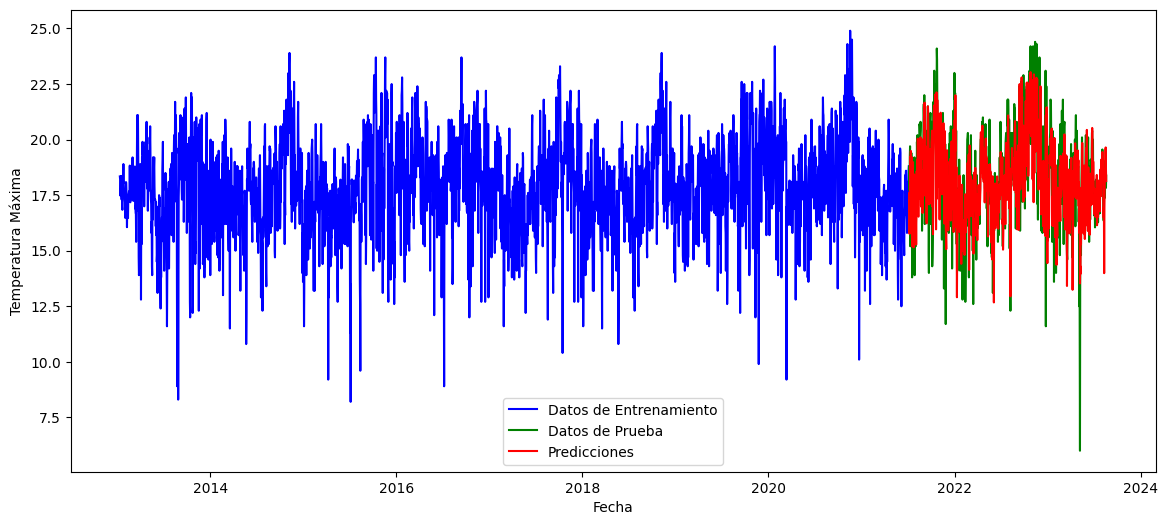

In [25]:
plt.figure(figsize=(14, 6))
plt.plot(df['Fecha'].iloc[:len(X_train)], y_train, label='Datos de Entrenamiento', color='blue')
plt.plot(df['Fecha'].iloc[len(X_train):], y_test, label='Datos de Prueba', color='green')
plt.plot(df['Fecha'].iloc[len(X_train):], y_test_pred, label='Predicciones', color='red')
plt.xlabel('Fecha')
plt.ylabel('Temperatura Máxima')
# plt.title('Comparación de Datos Reales y Predicciones')
plt.legend()
# plt.grid()
plt.show()

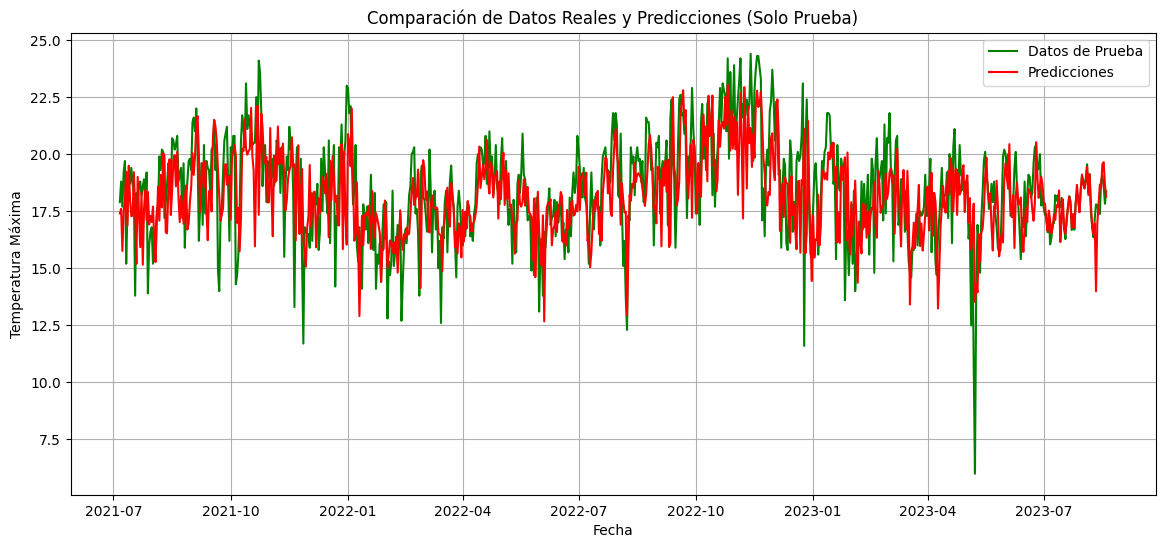

In [26]:
# PLOT PREDICTION WITH THE TEST
plt.figure(figsize=(14, 6))
plt.plot(df['Fecha'].iloc[len(X_train):], y_test, label='Datos de Prueba', color='green')
plt.plot(df['Fecha'].iloc[len(X_train):], y_test_pred, label='Predicciones', color='red')
plt.xlabel('Fecha')
plt.ylabel('Temperatura Máxima')
plt.title('Comparación de Datos Reales y Predicciones (Solo Prueba)')
plt.legend()
plt.grid()
plt.show()

# **FUTURE PREDICTIONS**

In [27]:
# Número de días a predecir en el futuro
future_days = 150

# Crear un DataFrame para las predicciones futuras
future_dates = pd.date_range(start=df['Fecha'].iloc[-1] + pd.Timedelta(days=1), periods=future_days, freq='D')
# future_dates = pd.date_range(start=df['Fecha'].iloc[-1] + pd.Timedelta(days=1), periods=future_days, freq='M')
future_df = pd.DataFrame({'Fecha': future_dates})

# Usar las últimas observaciones como características para predecir el futuro
# Asegúrate de que estás obteniendo el número correcto de lags (en este caso, 7)
last_observations = df.drop(columns=['Fecha', 'Temp_max']).iloc[-1].values  # Cambiado de [-7:] a [-1]

# Inicializar una lista para almacenar las predicciones futuras
future_predictions = []

# Iterar sobre el número de días a predecir
for i in range(future_days):
    # Crear un DataFrame temporal con las características para predecir
    # Asegúrate de que la forma de los datos coincida con lo que espera el modelo
    temp_df = pd.DataFrame([last_observations], columns=features.columns)

    # Predecir el próximo valor
    future_pred = model.predict(temp_df)[0]

    # Agregar la predicción al DataFrame futuro
    future_df.loc[i, 'Temp_max'] = future_pred

    # Actualizar las observaciones para la siguiente predicción
    last_observations = np.roll(last_observations, -1)  # Rueda los valores para dejar espacio para el nuevo
    last_observations[-1] = future_pred  # Añadir la nueva predicción al final

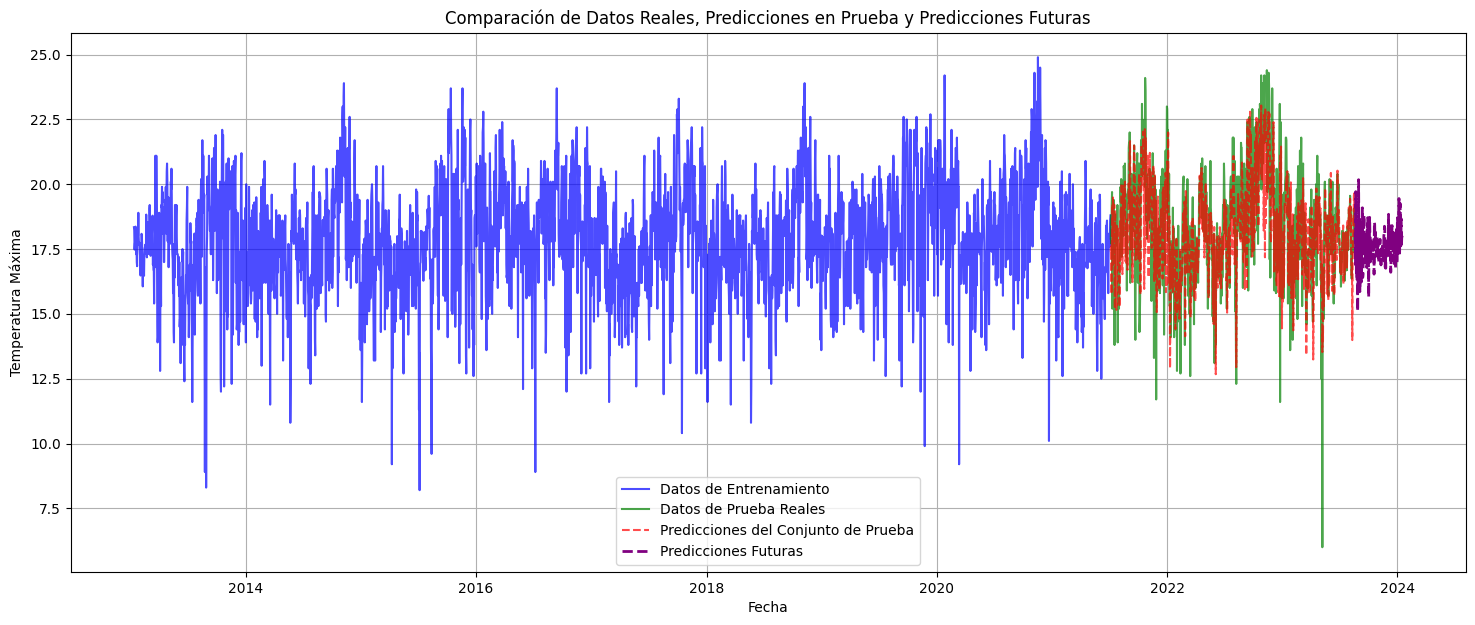

In [30]:
# Gráfico que incluye los datos de entrenamiento, prueba, predicciones del conjunto de prueba y predicciones futuras
plt.figure(figsize=(18, 7))
plt.plot(df['Fecha'].iloc[:len(X_train)], y_train, label='Datos de Entrenamiento', color='blue', alpha=0.7)
plt.plot(df['Fecha'].iloc[len(X_train):], y_test, label='Datos de Prueba Reales', color='green', alpha=0.7)
plt.plot(df['Fecha'].iloc[len(X_train):], y_test_pred, label='Predicciones del Conjunto de Prueba', color='red', linestyle='dashed', alpha=0.7)
plt.plot(future_df['Fecha'], future_df['Temp_max'], label='Predicciones Futuras', color='purple', linestyle='dashed', linewidth=2)
plt.xlabel('Fecha')
plt.ylabel('Temperatura Máxima')
plt.title('Comparación de Datos Reales, Predicciones en Prueba y Predicciones Futuras')
plt.legend()
plt.grid(True)
plt.show()

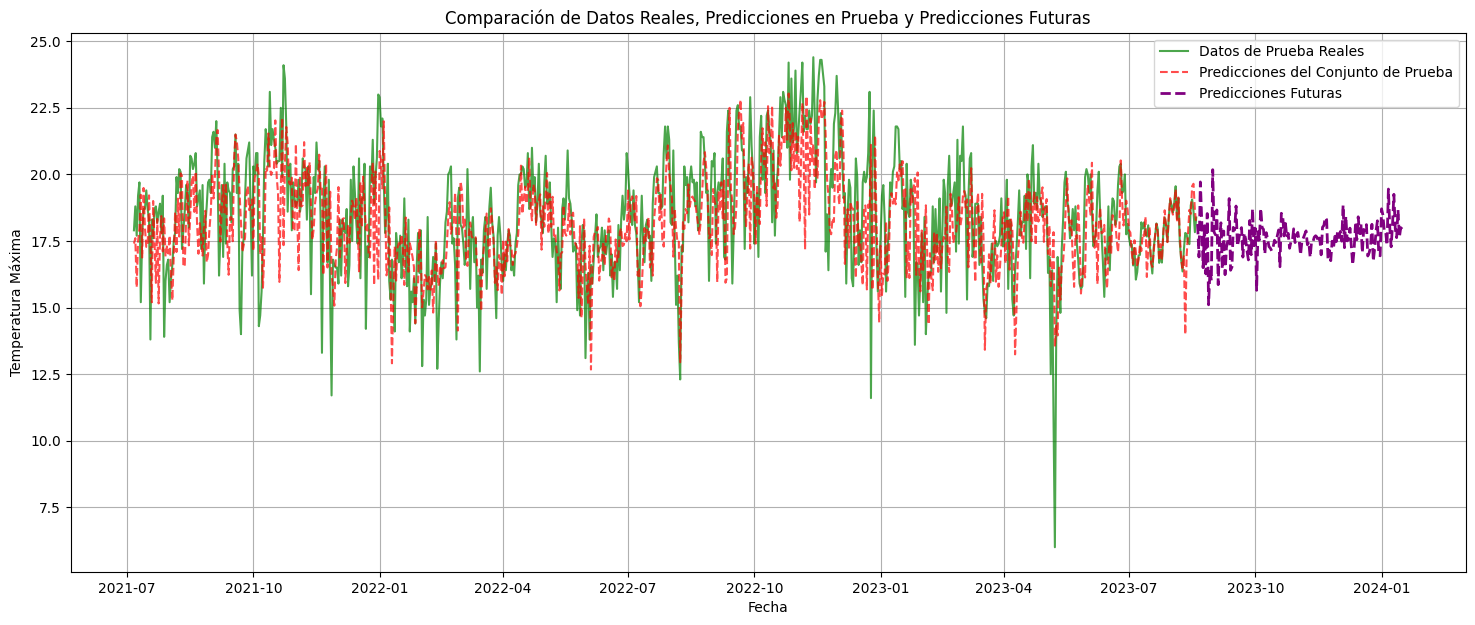

In [31]:
# Gráfico que incluye los datos prueba, predicciones del conjunto de prueba y predicciones futuras
plt.figure(figsize=(18, 7))
plt.plot(df['Fecha'].iloc[len(X_train):], y_test, label='Datos de Prueba Reales', color='green', alpha=0.7)
plt.plot(df['Fecha'].iloc[len(X_train):], y_test_pred, label='Predicciones del Conjunto de Prueba', color='red', linestyle='dashed', alpha=0.7)
plt.plot(future_df['Fecha'], future_df['Temp_max'], label='Predicciones Futuras', color='purple', linestyle='dashed', linewidth=2)
plt.xlabel('Fecha')
plt.ylabel('Temperatura Máxima')
plt.title('Comparación de Datos Reales, Predicciones en Prueba y Predicciones Futuras')
plt.legend()
plt.grid(True)
plt.show()

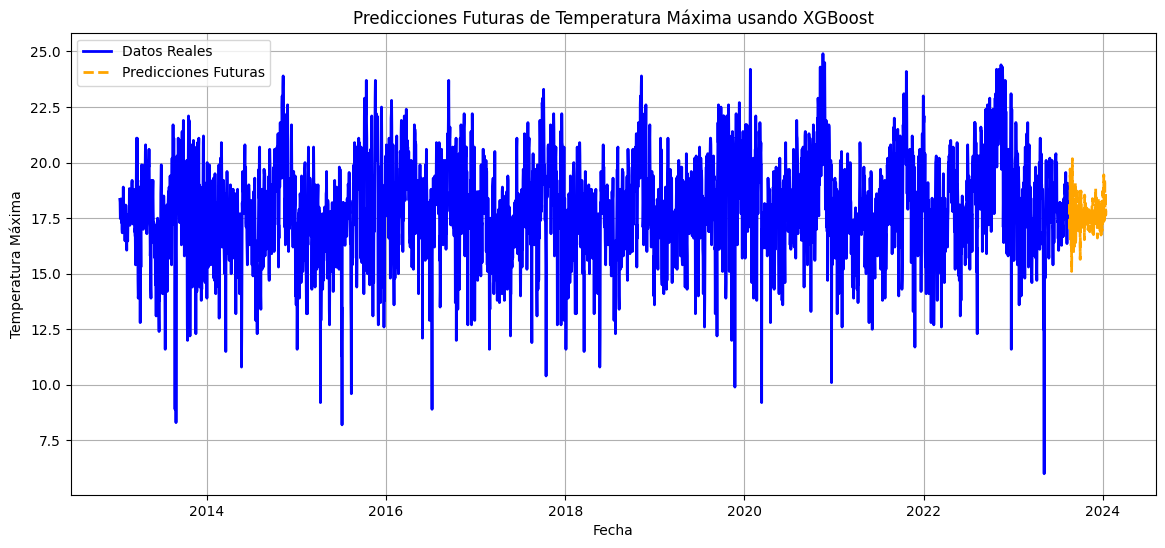

In [28]:
# Gráfico de las predicciones futuras
plt.figure(figsize=(14, 6))
plt.plot(df['Fecha'], df['Temp_max'], label='Datos Reales', color='blue', linewidth=2)
plt.plot(future_df['Fecha'], future_df['Temp_max'], label='Predicciones Futuras', color='orange', linestyle='dashed', linewidth=2)
plt.xlabel('Fecha')
plt.ylabel('Temperatura Máxima')
plt.title('Predicciones Futuras de Temperatura Máxima usando XGBoost')
plt.legend()
plt.grid()
plt.show()

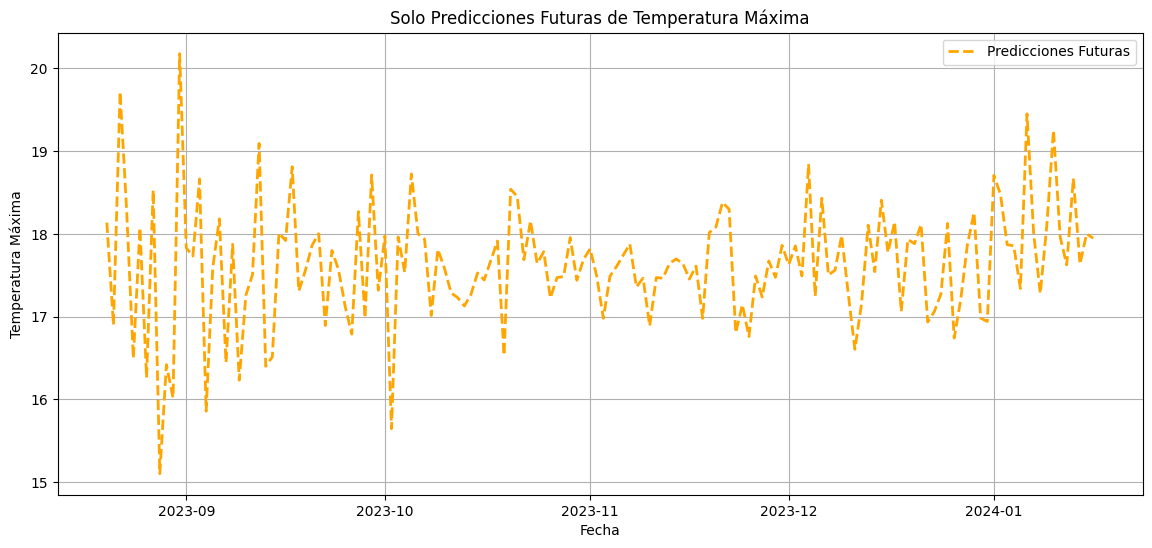

In [32]:
# Gráfico solo de las predicciones futuras
plt.figure(figsize=(14, 6))
plt.plot(future_df['Fecha'], future_df['Temp_max'], label='Predicciones Futuras', color='orange', linestyle='dashed', linewidth=2)
plt.xlabel('Fecha')
plt.ylabel('Temperatura Máxima')
plt.title('Solo Predicciones Futuras de Temperatura Máxima')
plt.legend()
plt.grid()
plt.show()